In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import sys
import copy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import geopandas as gpd
from ExKMC.Tree import Tree as ExTree
from intercluster.rules import *
from intercluster.pruning import *
from intercluster.experiments import *
from intercluster import *

%load_ext autoreload
%autoreload 2

In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 342
np.random.seed(seed)

In [6]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this aside from font.size
# To get tex working on linux run the following:
# `sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super`
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

subset_colors = [cmap(0), cmap(1), cmap(3), cmap(4), cmap(5), cmap(6), cmap(7)]
cmap_subset = ListedColormap(subset_colors)

cmap2 = ["white", cmap(5)]
cmap2 = ListedColormap(cmap2)

subset_colors = [cmap(5), cmap(6), cmap(7), cmap(1), cmap(3), cmap(0)]
cmap3 = ListedColormap(subset_colors)

### Data

In [8]:
shapefile_path = '../data/climate_divisions/climate_divisions.shp'
dtype_dict = {'CLIMDIV': 'str'}
gdf = gpd.read_file(shapefile_path, dtype = dtype_dict)
gdf['CLIMDIV'] = gdf['CLIMDIV'].apply(lambda x: f'{int(x):04d}')

/home/kevinq/interpretable/.venv/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option DTYPE
  return ogr_read(


In [9]:
climate_data = pd.read_csv('../data/climate.csv', dtype={'ID': str, 'Year': str})
climate_data.set_index(['ID', 'Year'], inplace=True)

historical_years = [str(i) for i in range(1900,2000)]
recent_years = [str(i) for i in range(2013,2024)]

historical = climate_data.loc[pd.IndexSlice[:, historical_years], :]
recent = climate_data.loc[pd.IndexSlice[:, recent_years], :]

historical_avg = historical.groupby(level='ID').mean()
recent_avg = recent.groupby(level='ID').mean()

climate_change = (recent_avg - historical_avg)/historical_avg
climate_change = climate_change.loc[gdf.CLIMDIV,:]

In [10]:
# change months to seasons\n",
groupings = {'pcpn_winter': ['pcpn_dec', 'pcpn_jan', 'pcpn_feb'],
            'pcpn_spring': ['pcpn_mar', 'pcpn_apr', 'pcpn_may'],
            'pcpn_summer': ['pcpn_june', 'pcpn_july', 'pcpn_aug'],
            'pcpn_fall': ['pcpn_sept', 'pcpn_oct', 'pcpn_nov'],
            'temp_winter': ['temp_dec', 'temp_jan', 'temp_feb'],
            'temp_spring': ['temp_mar', 'temp_apr', 'temp_may'],
            'temp_summer': ['temp_june', 'temp_july', 'temp_aug'],
            'temp_fall': ['temp_sept', 'temp_oct', 'temp_nov']}

seasonal_historical = pd.DataFrame()
seasonal_recent = pd.DataFrame()
seasonal_climate_change = pd.DataFrame()

# Calculate the average for each group of months
for group_name, columns in groupings.items():
    seasonal_historical[group_name] = historical_avg[columns].mean(axis=1)
    seasonal_recent[group_name] = recent_avg[columns].mean(axis=1)
    seasonal_climate_change[group_name] = climate_change[columns].mean(axis=1)

In [11]:
unscaled_data = climate_change.to_numpy()
feature_labels = climate_change.columns

scaler = MinMaxScaler()
data = scaler.fit_transform(unscaled_data)

### Running Experiments

In [9]:
# REMINDER: The seed should only be given to the experiment object which 
# initializes the seed at the beginning of the experiment. It should NOT 
# within the parameters of any sub-function or class, since these will 
# reset the seed each time they are given one. 
np.random.seed(919817)

In [17]:
k = 7

In [56]:
# Parameters:
k = 7
n_clusters = k
min_rules = k
max_rules = 2*k
min_depth = 3
max_depth = 6
n_trees = 100

# Base module
base = KMeansBase(n_clusters)
A,C = base.assign(data)
y = base.clustering.labels_

# Modules:
mod1 = ExkmcMod(
    n_clusters = n_clusters,
    kmeans_model = base.clustering,
    base_tree = 'IMM',
    min_rules = min_rules
)

# Forest:
forest_tree_params = {
    'max_leaf_nodes' : max_rules,
    'max_depth' : 2
}

forest_params1 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params,
    'num_trees' : n_trees,
    'max_features' : 6,
    'max_labels' : 1,
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.75
}

prune_objective1 = KmeansObjective(
    X = data,
    centers = C,
    normalize = True,
    threshold = 0.9
)

prune_params1 = {
    'k' : k,
    'X' : data,
    'y' : [[l] for l in y],
    'objective' : prune_objective1,
    'lambda_search_range' : np.linspace(0,2,101)
}

mod2 = ForestMod(
    forest_model = DecisionForest,
    forest_params = forest_params1,
    clustering = base,
    prune_params = prune_params1,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'Forest'
)

prune_objective2 = KmeansObjective(
    X = data,
    centers = C,
    normalize = True,
    threshold = 1
)

prune_params2 = {
    'k' : k,
    'X' : data,
    'y' : [[l] for l in y],
    'objective' : prune_objective2,
    'lambda_search_range' : np.linspace(0,2,101)
}

mod3 = ForestMod(
    forest_model = DecisionForest,
    forest_params = forest_params1,
    clustering = base,
    prune_params = prune_params2,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'Forest-Full-Cover'
)

'''
forest_tree_params2 = {
    'max_leaf_nodes' : max_rules,
    'max_depth' : 1
}

forest_params2 = {
    'tree_model' : SVMTree,
    'tree_params' : forest_tree_params2,
    'num_trees' : n_trees,
    'max_features' : 2,
    'max_labels' : 1,
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.75
}

prune_params2 = {
    'search_range' : np.linspace(0,1,100),
    'coverage_threshold' : 0.5 * len(data)
}

mod3 = ForestMod(
    forest_model = DecisionForest,
    forest_params = forest_params2,
    clustering = base,
    prune_params = prune_params2,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'SVM-Forest'
)
'''

baseline_list = [base]
module_list = [mod1, mod2, mod3]

In [61]:
# Computing statistics:
#df = Ex1_results
df = pd.read_csv("../data/experiments/decision_sets/rules_cost_climate_new3.csv", header=[0, 1, 2], index_col=0)
grouped = df.T.groupby(level = [0,1])
mean_df = grouped.mean().T
std_df = grouped.std().T

### Plotting

In [62]:
def experiment_plotter(mean_df, std_df, xlabel, ylabel, domain, cmap, legend = True, filename = None, baseline_list = None):
    fig,ax = plt.subplots(figsize = (6,4))
    if baseline_list is None:
        baseline_list = ['KMeans']
    baseline_linestyles = ['-']
    baselines = [_ for _ in mean_df.columns if _ in baseline_list]
    modules = [_ for _ in mean_df.columns if _ not in baselines]
    
    end = -1
    for i,b in enumerate(baselines):
        ax.hlines(
            mean_df[b].iloc[0],
            xmin = domain[0],
            xmax = domain[end],
            color = 'k',
            label = fr'$\texttt{{{b}}}$',
            linestyle = baseline_linestyles[i],
            linewidth = 3,
            alpha = 0.6
        )
    
    for i,m in enumerate(modules):
        ax.plot(
            domain,
            np.array(mean_df[m]),
            linewidth = 3,
            marker='o',
            markersize = 5,
            c = cmap(i),
            label = fr'$\texttt{{{m}}}$'
        )
        ax.fill_between(
            domain, 
            np.array(mean_df[m]) - np.array(std_df[m]),
            np.array(mean_df[m]) + np.array(std_df[m]),
            color= cmap(i),
            alpha=0.1
        )

    ticks = np.arange(domain[0], domain[end] + 1, 1) 
    labels = [str(i) for i in ticks] 
    plt.xticks(ticks, labels)

    if legend:
        plt.legend(loc = 'upper right', bbox_to_anchor=(2, 1))
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if filename is not None:
        plt.savefig(filename, bbox_inches = 'tight', dpi = 300)
    #plt.show()

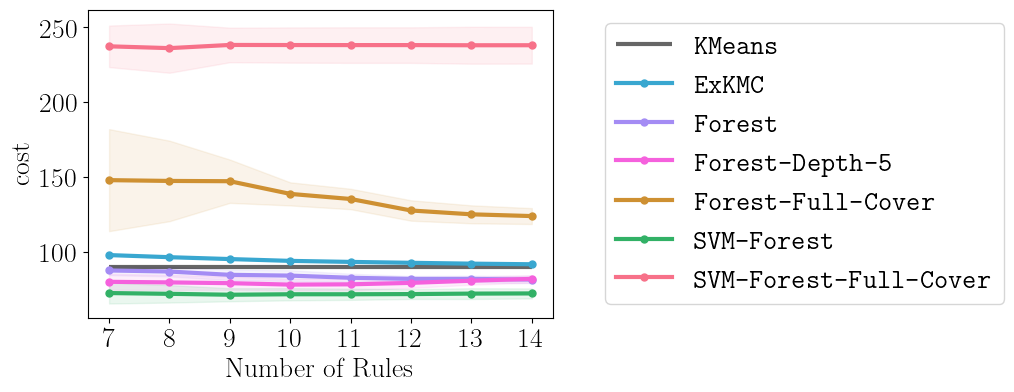

In [63]:
fname = None
#fname = '../figures/decision_sets/cost.png'
experiment_plotter(
    mean_df['point-average-clustering-cost'],
    std_df['point-average-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'cost',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap3,
    legend = True,
    filename = fname
)
#plt.ylim(80,110)

(0.2, 0.35)

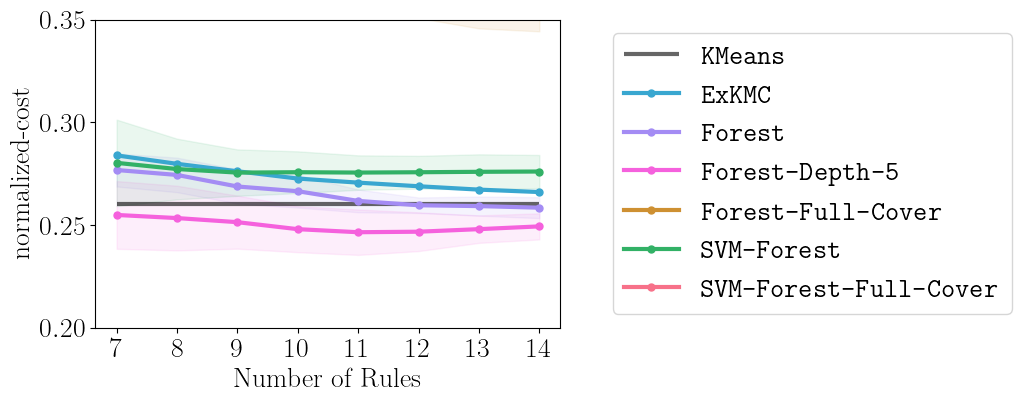

In [76]:
fname = None
#fname = '../figures/decision_sets/normalized_cost.png'
experiment_plotter(
    mean_df['normalized-clustering-cost'],
    std_df['normalized-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'normalized-cost',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap3,
    legend = True,
    filename = fname
)
plt.ylim(0.2,0.35)

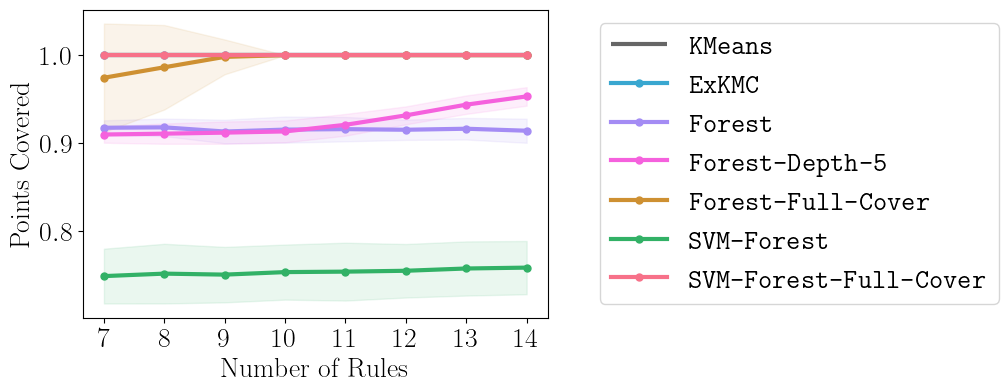

In [65]:
fname = None
#fname = '../figures/decision_sets/coverage.png'
experiment_plotter(
    mean_df['coverage'],
    std_df['coverage'],
    xlabel = 'Number of Rules',
    ylabel = 'Points Covered',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap3,
    legend = True,
    filename = fname
)

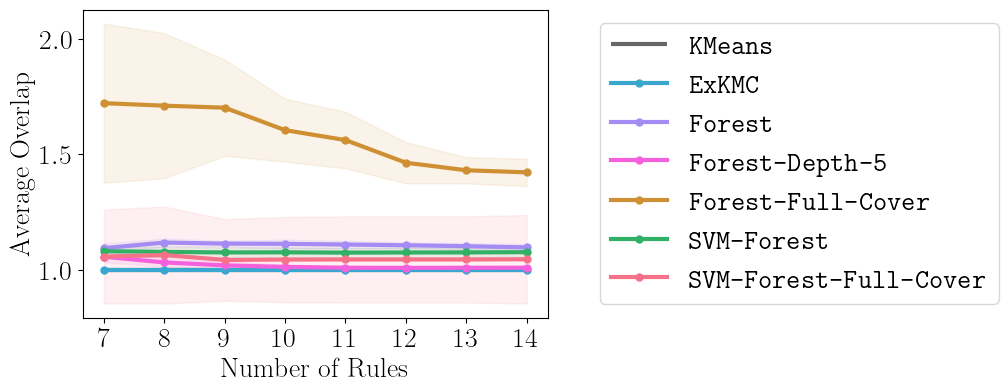

In [66]:
fname = None
#fname = '../figures/decision_sets/overlap.png'
experiment_plotter(
    mean_df['overlap'],
    std_df['overlap'],
    xlabel = 'Number of Rules',
    ylabel = 'Average Overlap',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap3,
    legend = True,
    filename = None
)

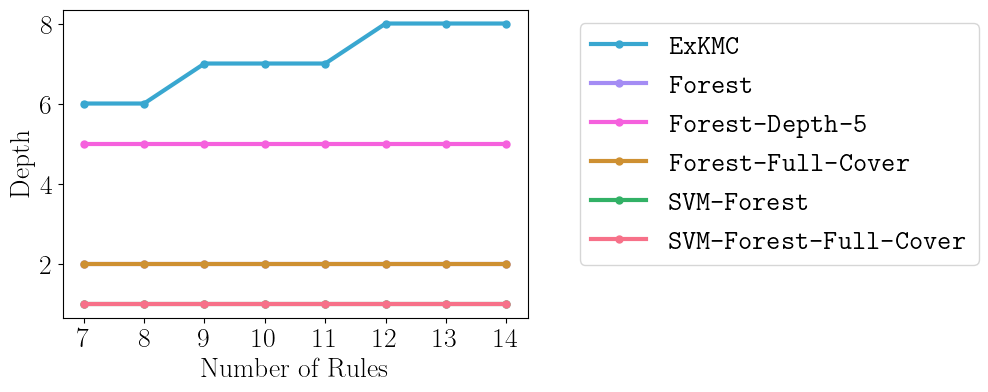

In [67]:
fname = None
#fname = '../figures/decision_sets/depth.png'
experiment_plotter(
    mean_df['depth'],
    std_df['depth'],
    xlabel = 'Number of Rules',
    ylabel = 'Depth',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap3,
    legend = True,
    filename = fname
)

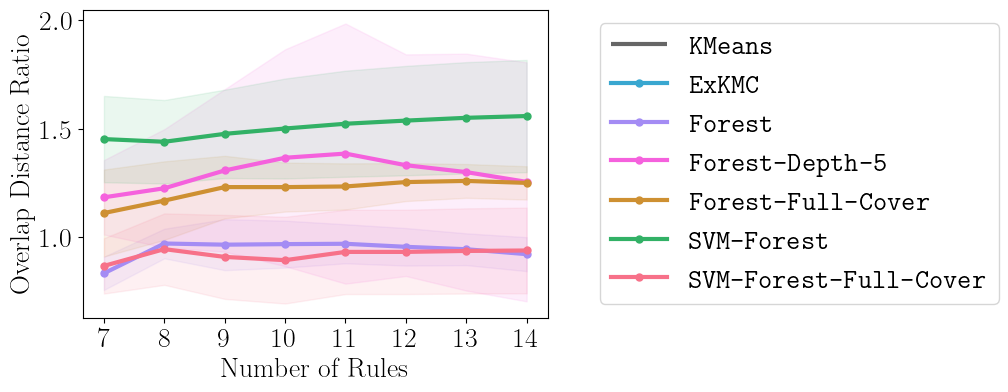

In [68]:
fname = None
#fname = '../figures/decision_sets/depth.png'
experiment_plotter(
    mean_df['overlap-distance'],
    std_df['overlap-distance'],
    xlabel = 'Number of Rules',
    ylabel = 'Overlap Distance Ratio',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap3,
    legend = True,
    filename = fname
)

In [69]:
df = pd.read_csv("../data/experiments/decision_sets/rules_cost_comparison_climate.csv", header=[0, 1, 2], index_col=0)
grouped = df.T.groupby(level = [0,1])
mean_df2 = grouped.mean().T
std_df2 = grouped.std().T

In [70]:
mean_df2

depth        point-average-clustering-cost                      
  ExKMC Forest                         ExKMC     Forest     KMeans
0   6.0    2.0                     84.216055  87.148234  78.185549
1   7.0    2.0                     82.892575  86.267293  78.113756
2   7.0    2.0                     80.831608  83.448728  77.073059
3   8.0    2.0                     80.796382  83.512049  77.865693
4   8.0    2.0                     80.853405  82.295994  78.358503
5   8.0    2.0                     80.302474  81.558899  78.295582
6   8.0    2.0                     79.926218  81.418129  78.308294
7   8.0    2.0                     79.947245  81.177051  78.373196

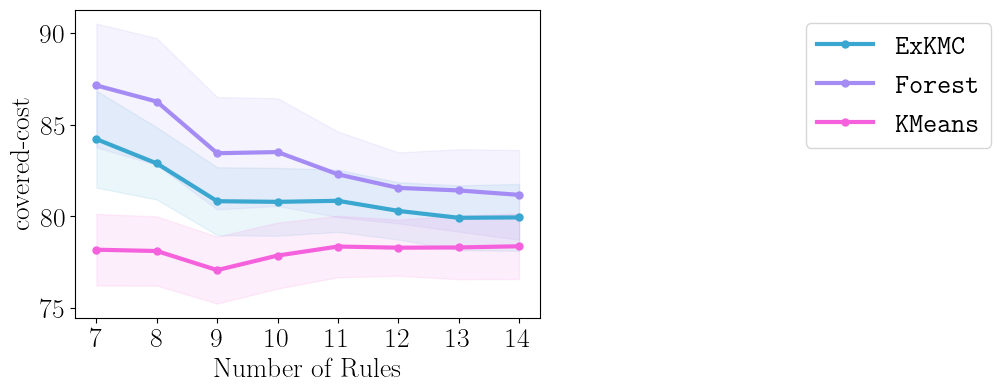

In [71]:
fname = None
#fname = '../figures/decision_sets/cost.png'
experiment_plotter(
    mean_df2['point-average-clustering-cost'],
    std_df2['point-average-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'covered-cost',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap3,
    legend = True,
    filename = fname,
    baseline_list = []
)